边缘检测
===

# 1.Canny边缘检测
Canny边缘检测分为四步：
- 使用高斯滤波
- 在$x$方向和$y$方向上使用Sobel滤波器，在此之上求出边缘的强度和边缘的梯度；
- 对梯度幅值进行非极大值抑制(Non-maximum suppression)来使边缘变得更细；
- 使用滞后阈值来对阈值进行处理。

## 1.1.高斯滤波

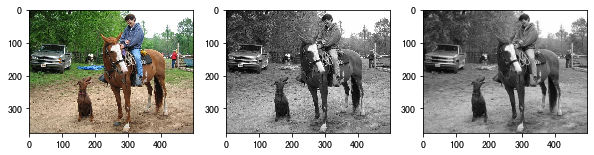

In [7]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np


img = cv2.imread("Images/01/09/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def BGR2GRAY(img):
    b = img[:, :, 0].copy()
    g = img[:, :, 1].copy()
    r = img[:, :, 2].copy()

    # Gray scale
    out = 0.2126 * r + 0.7152 * g + 0.0722 * b
    out = out.astype(np.uint8)

    return out

def gaussian_filter(img, K_Size = 3, sigma=1.3):
    if len(img.shape) == 3:
        H, W, C = img.shape
    else:
        img = np.expand_dims(img, axis=-1)
        H, W, C = img.shape
    
	## Zero padding
    pad = K_Size // 2
    out_filter = np.zeros((H + pad * 2, W + pad * 2, C), dtype=np.float)
    out_filter[pad: pad + H, pad: pad + W] = img.copy().astype(np.float)

    ## prepare Kernel
    K = np.zeros((K_Size, K_Size), dtype=np.float)
    for x in range(-pad, -pad + K_Size):
        for y in range(-pad, -pad + K_Size):
            K[y + pad, x + pad] = np.exp( -(x ** 2 + y ** 2) / (2 * (sigma ** 2)))
    K /= (2 * np.pi * sigma * sigma)
    K /= K.sum()

    tmp = out_filter.copy()

    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out_filter[pad + y, pad + x, c] = np.sum(K * tmp[y: y + K_Size, x: x + K_Size, c])
    out_filter = np.clip(out_filter, 0, 255)
    out_filter = out_filter[pad: pad + H, pad: pad + W].astype(np.uint8)

    return out_filter

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1) 
plt.imshow(img)

gray = BGR2GRAY(img)
plt.subplot(1, 3, 2) 
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

gaussian_out = gaussian_filter(gray)
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(gaussian_out, cv2.COLOR_BGR2RGB))

## 1.2.使用Sobel滤波器

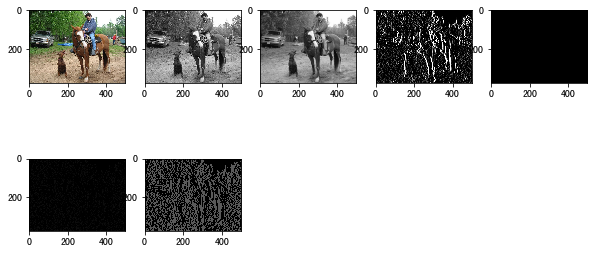

In [25]:
def sobel_filter(img, K_size=3):
    if len(img.shape) == 3:
        H, W, C = img.shape
    else:
        #img = np.expand_dims(img, axis=-1)
        H, W = img.shape

    # Zero padding
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2, C), dtype=np.float)
    out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)
    tmp = out.copy()

    out_v = out.copy()
    out_h = out.copy()

    ## Sobel vertical
    Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
    ## Sobel horizontal
    Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

    # filtering
    for y in range(H):
        for x in range(W):
            out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
            out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

    out_v = np.clip(out_v, 0, 255)
    out_h = np.clip(out_h, 0, 255)

    out_v = out_v[pad : pad + H, pad : pad + W].astype(np.uint8)
    out_h = out_h[pad : pad + H, pad : pad + W].astype(np.uint8)

    return out_v, out_h

def get_edge_angle(fx, fy):
    edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
    fx = np.maximum(fx, 1e-5)
    angle = np.arctan(fy / fx)
    return edge, angle

def angle_quantization(angle):
    angle = angle / np.pi * 180
    angle[angle < -22.5] = 180 + angle[angle < -22.5]
    _angle = np.zeros_like(angle, dtype=np.uint8)
    _angle[np.where(angle <= 22.5)] = 0
    _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
    _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
    _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

    return _angle

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 5, 1) 
plt.imshow(img)

gray = BGR2GRAY(img)
plt.subplot(2, 5, 2) 
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

gaussian_out = gaussian_filter(gray, K_Size=5, sigma=1.4)
plt.subplot(2, 5, 3)
plt.imshow(cv2.cvtColor(gaussian_out, cv2.COLOR_BGR2RGB))

sobel_y, sobel_x = sobel_filter(gaussian_out, K_size=3)
plt.subplot(2, 5, 4)
plt.imshow(cv2.cvtColor(sobel_y, cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 5)
plt.imshow(cv2.cvtColor(sobel_x, cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 6)
edge, angle = get_edge_angle(sobel_x, sobel_y)
plt.imshow(cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2RGB))

angle = angle_quantization(angle)
plt.subplot(2, 5, 7)
plt.imshow(cv2.cvtColor(angle.astype(np.uint8), cv2.COLOR_BGR2RGB))

## 1.3.NMS
非极大值抑制是对除去非极大值以外的值的操作的总称.在这里，我们比较我们所关注的地方梯度的法线方向邻接的三个像素点的梯度幅值，如果该点的梯度值不比其它两个像素大，那么这个地方的值设置为0。也就是说，我们在注意梯度幅值$edge(x,y)$的时候，可以根据下式由梯度方向$angle(x,y)$来变换$edge(x,y)$
- $angle(x,y)=0$:如果在$edge(x,y)$、$edge(x−1,y)$、$edge(x+1,y)$中$edge(x,y)$不是最大的，那么$edge(x,y)=0$；
- $angle(x,y)=45$:如果在$edge(x,y)$、$edge(x−1,y)$、$edge(x+1,y)$中$edge(x,y)$不是最大的，那么$edge(x,y)=0$；
- $angle(x,y)=90$:如果在$edge(x,y)$、$edge(x−1,y)$、$edge(x+1,y)$中$edge(x,y)$不是最大的，那么$edge(x,y)=0$；
- $angle(x,y)=135$:如果在$edge(x,y)$、$edge(x−1,y)$、$edge(x+1,y)$中$edge(x,y)$不是最大的，那么$edge(x,y)=0$；

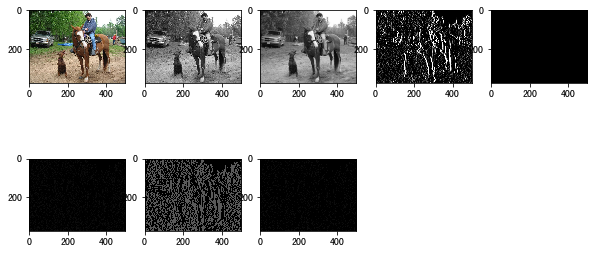

In [28]:
def non_maximum_suppression(angle, edge):
    H, W,C = angle.shape
    _edge = edge.copy()

    for y in range(H):
        for x in range(W):
                if angle[y, x] == 0:
                        dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[y, x] == 45:
                        dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[y, x] == 90:
                        dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[y, x] == 135:
                        dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                if x == 0:
                        dx1 = max(dx1, 0)
                        dx2 = max(dx2, 0)
                if x == W-1:
                        dx1 = min(dx1, 0)
                        dx2 = min(dx2, 0)
                if y == 0:
                        dy1 = max(dy1, 0)
                        dy2 = max(dy2, 0)
                if y == H-1:
                        dy1 = min(dy1, 0)
                        dy2 = min(dy2, 0)
                if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
                        _edge[y, x] = 0

    return _edge
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 5, 1) 
plt.imshow(img)

gray = BGR2GRAY(img)
plt.subplot(2, 5, 2) 
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

gaussian_out = gaussian_filter(gray, K_Size=5, sigma=1.4)
plt.subplot(2, 5, 3)
plt.imshow(cv2.cvtColor(gaussian_out, cv2.COLOR_BGR2RGB))

sobel_y, sobel_x = sobel_filter(gaussian_out, K_size=3)
plt.subplot(2, 5, 4)
plt.imshow(cv2.cvtColor(sobel_y, cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 5)
plt.imshow(cv2.cvtColor(sobel_x, cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 6)
edge, angle = get_edge_angle(sobel_x, sobel_y)
plt.imshow(cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2RGB))

angle = angle_quantization(angle)
plt.subplot(2, 5, 7)
plt.imshow(cv2.cvtColor(angle.astype(np.uint8), cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 8)
edge = non_maximum_suppression(angle, edge)
plt.imshow(cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2RGB))


## 1.4.最后处理
我们将通过设置高阈(HT：high threshold)和低阈值(LT：low threshold)来将梯度幅值二值化。
- 如果梯度幅值$edge(x,y)$大于高阈值的话，令$edge(x,y)=255$；
- 如果梯度幅值$edge(x,y)$小于低阈值的话，令$edge(x,y)=0$；
- 如果梯度幅值$edge(x,y)$介于高阈值和低阈值之间并且周围8邻域内有比高阈值高的像素点存在，令$edge(x,y)=255$；

在这里，我们使高阈值为100，低阈值为20。顺便说一句，阈值的大小需要边看结果边调整。

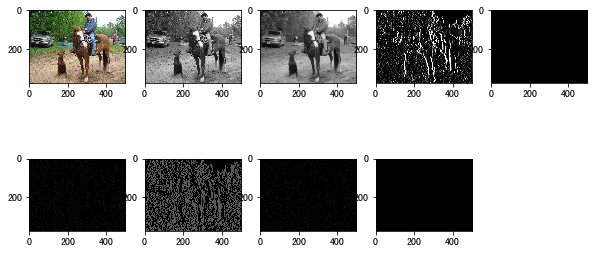

In [33]:
def hysterisis(edge, HT=100, LT=30):
    H, W, C = edge.shape

    # Histeresis threshold
    edge[edge >= HT] = 255
    edge[edge <= LT] = 0

    _edge = np.zeros((H + 2, W + 2, C), dtype=np.float32)
    _edge[1 : H + 1, 1 : W + 1] = edge

    ## 8 - Nearest neighbor
    nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

    for y in range(1, H+2):
            for x in range(1, W+2):
                    if _edge[y, x] < LT or _edge[y, x] > HT:
                            continue
                    if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
                            _edge[y, x] = 255
                    else:
                            _edge[y, x] = 0

    edge = _edge[1:H+1, 1:W+1]
                            
    return edge

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 5, 1) 
plt.imshow(img)

gray = BGR2GRAY(img)
plt.subplot(2, 5, 2) 
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

gaussian_out = gaussian_filter(gray, K_Size=5, sigma=1.4)
plt.subplot(2, 5, 3)
plt.imshow(cv2.cvtColor(gaussian_out, cv2.COLOR_BGR2RGB))

sobel_y, sobel_x = sobel_filter(gaussian_out, K_size=3)
plt.subplot(2, 5, 4)
plt.imshow(cv2.cvtColor(sobel_y, cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 5)
plt.imshow(cv2.cvtColor(sobel_x, cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 6)
edge, angle = get_edge_angle(sobel_x, sobel_y)
plt.imshow(cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2RGB))

angle = angle_quantization(angle)
plt.subplot(2, 5, 7)
plt.imshow(cv2.cvtColor(angle.astype(np.uint8), cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 8)
edge = non_maximum_suppression(angle, edge)
plt.imshow(cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2RGB))

plt.subplot(2, 5, 9)
edge = hysterisis(angle)
plt.imshow(cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2RGB))